# Purpose:
- Build logistic regression using whisker features
- Infer important whisker features in angle discrimination
- Try angle discrimination using single feature
- Look at the difference between sessions

In [1]:
import numpy as np
import pandas as pd
from importlib import reload
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('default')
import utils.clustering_index as ci
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import utils.lda_angle_discrim as lda_angle
from sklearn.linear_model import LogisticRegression
import xarray as xr

base_dir = Path(r'E:\TPM\JK\h5')
results_dir = base_dir / 'results'
wf_dir = results_dir / 'touch_whisker_features'
pr_dir = results_dir / 'pop_responses' / 'touch_before_answer'

expert_mice_df = pd.read_csv(base_dir / 'expert_mice.csv', index_col=0)
use_mice_df = expert_mice_df.loc[expert_mice_df['depth_matched'].astype(bool) & 
                                 ~expert_mice_df['processing_error'].astype(bool) &
                                 ((expert_mice_df.session_type == 'training') |
                                  (expert_mice_df.session_type.str.contains('test')))]
use_volume_df = use_mice_df.query('plane in [1, 5]')
use_volume_df.loc[:, 'volume'] = use_volume_df['plane'].apply(lambda x: 1 if x==1 else 2)
training_volume_df = use_volume_df.query('session_type == "training"')
remove_ind = training_volume_df.query('mouse==27 and session=="15"')
training_volume_df = training_volume_df.drop(remove_ind.index)
remove_ind = training_volume_df.query('mouse==36 and session=="9"')
training_volume_df = training_volume_df.drop(remove_ind.index)

mice = [25,27,30,36,39,52]
test_sessions = [[4,19], [3,8], [3,21], [1,17], [1,23], [3,21]]
naive_sessions = [10, 4, 11, 6, 6, 11]

c:\Users\shires\Anaconda3\envs\suite2p\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [6]:
mi = 0
mouse = mice[mi]
sessions = np.sort([int(s) for s in use_mice_df.query('mouse==@mouse and session_type=="training"')['session'].unique()])
si = 0
session = sessions[si]
wf_df = pd.read_pickle(wf_dir / f'JK{mouse:03}S{session:02}_touch_whisker_features.pkl')
wf_df_before_answer = wf_df.groupby('trialNum').apply(
    lambda x: x.query('touch_offset_time < answer_lick_time')).reset_index(
        drop=True)
wf_df_before_answer

,trialNum,touch_onset_time,touch_offset_time,answer_lick_time,touch_duration,slide_distance,theta_onset,phi_onset,kappaH_onset,kappaV_onset,arcLength_onset,delta_theta,delta_kappaH,delta_phi,delta_kappaV
0,2,1.641820,1.645033,2.621974,0.003213,0.051033,0.087511,-3.665535,0.044734,-0.051098,5.261802,0.000000,0.000000,-0.263482,-0.006014
1,2,1.677162,1.683588,2.621974,0.006426,0.053029,3.056956,-3.131719,0.042326,-0.050991,5.250117,0.000000,0.000000,1.940506,-0.008177
2,2,1.702866,1.712505,2.621974,0.009639,0.272299,3.815146,-2.286458,0.028474,-0.051796,5.149981,0.563682,-0.007285,2.071100,0.003267
3,2,1.776764,1.776764,2.621974,0.000000,0.000000,-3.952790,-5.403471,0.037733,-0.050567,5.287988,0.000000,0.000000,0.000000,0.000000
4,2,1.818532,1.831384,2.621974,0.012852,0.490961,-4.444834,-4.099098,0.045884,-0.055573,5.354224,1.942225,-0.011300,0.848516,0.006600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2691,593,1.914921,1.918134,2.598823,0.003213,0.138395,10.742139,10.268899,0.031381,-0.051419,5.521962,0.004849,-0.012090,0.563277,-0.001783
2692,593,2.226578,2.229791,2.598823,0.003213,0.095155,6.230131,-3.171821,0.034044,-0.053164,5.342374,0.000000,0.000000,2.398533,-0.005518
2693,593,2.380799,2.384012,2.598823,0.003213,0.038251,5.713396,-1.547022,0.040733,-0.057790,5.272232,0.000000,0.000000,-1.423289,-0.001433
2694,593,2.441846,2.464336,2.598823,0.022491,0.753948,3.805090,-2.172369,0.024160,-0.055099,5.330518,0.324542,-0.009625,3.364925,-0.011123


In [7]:
b_dir = Path(r'E:\TPM\JK\SoloData')
b_fn = b_dir / f'JK{mouse:03}/JK{mouse:03}S{session:02}_behavior.pkl'
b_df = pd.read_pickle(b_fn)
b_df

,answerLickTime,answerPeriodTime,beamBreakTimesLeft,beamBreakTimesRight,choice,drinkingTime,extraITIOnErrorSetting,motorApPosition,motorDistance,poleDownOnsetTime,...,rewardTimeLeft,rewardTimeRight,samplingPeriodTime,servoAngle,trialType,mouse_name,session_name,session_type,task_target,distractor
trialNum,,,,,,,,,,,,,,,,,,,,,
1,0,"[2.551833, 3.55198]","[252.323834, 252.58665100000002, 252.716817, 2...","[254.79730800000002, 409.97037, 416.1704959999...",m,"[0, 0]",0.0,35000,100000,3.551980,...,"[0, 0]","[0, 0]","[1.051657, 2.551833]",135,ln,JK025,S01,2port-Discrim,Angle,Off
2,2.621974,"[2.5523079999998117, 2.621973999999909]","[1.0996470000000045, 1.3511459999999715, 2.357...",1.89666,l,"[2.732140999999956, 3.7323189999999613]",0.0,65648,130000,3.732319,...,"[2.621973999999909, 2.732140999999956]","[0, 0]","[1.0521469999998772, 2.5523079999998117]",135,ln,JK025,S01,2port-Discrim,Angle,Off
3,2.78314,"[2.5529740000001766, 2.783140000000003]","[0.3506489999999758, 0.7413300000000618, 1.325...",0,l,"[0, 0]",0.0,63826,130000,2.793322,...,"[0, 0]","[0, 0]","[1.0528289999999743, 2.5529740000001766]",45,rn,JK025,S01,2port-Discrim,Angle,Off
4,0,"[2.552662000000055, 3.5526680000000397]","[0.0161830000001828, 0.21834800000010546, 0.49...","[4.0766510000000835, 4.191332000000102, 4.3148...",m,"[0, 0]",0.0,61361,130000,3.552668,...,"[0, 0]","[0, 0]","[1.0524960000000192, 2.552662000000055]",45,rn,JK025,S01,2port-Discrim,Angle,Off
5,0,"[2.5531570000000556, 3.5533190000001014]","[0.0019999999999527063, 1.9399920000000748, 1....",4.052817,m,"[0, 0]",0.0,60919,130000,3.553319,...,"[0, 0]","[0, 0]","[1.0529959999998937, 2.5531570000000556]",135,ln,JK025,S01,2port-Discrim,Angle,Off
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
610,0,"[2.5524740000000747, 3.552636999999777]",0,0,m,"[0, 0]",0.0,67530,130000,3.552637,...,"[0, 0]","[0, 0]","[1.0523290000000998, 2.5524740000000747]",45,rn,JK025,S01,2port-Discrim,Angle,Off
611,0,"[2.5518229999997857, 3.5519699999995282]",0,0,m,"[0, 0]",0.0,61850,130000,3.551970,...,"[0, 0]","[0, 0]","[1.05164700000023, 2.5518229999997857]",135,ln,JK025,S01,2port-Discrim,Angle,Off
612,0,"[2.5521570000000793, 3.5523349999994025]",0,0,m,"[0, 0]",0.0,61201,130000,3.552335,...,"[0, 0]","[0, 0]","[1.0519960000001447, 2.5521570000000793]",135,ln,JK025,S01,2port-Discrim,Angle,Off


In [8]:
b_df.columns

Index(['answerLickTime', 'answerPeriodTime', 'beamBreakTimesLeft',
       'beamBreakTimesRight', 'choice', 'drinkingTime',
       'extraITIOnErrorSetting', 'motorApPosition', 'motorDistance',
       'poleDownOnsetTime', 'poleUpOnsetTime', 'rewardTimeLeft',
       'rewardTimeRight', 'samplingPeriodTime', 'servoAngle', 'trialType',
       'mouse_name', 'session_name', 'session_type', 'task_target',
       'distractor'],
      dtype='object')

In [9]:
def _get_outcome(x):
    if x.choice == 'm':
        return 'miss'
    elif x.choice == 'l':
        return 'correct' if x.trialType[0] == 'l' else 'wrong'
    elif x.choice == 'r':
        return 'correct' if x.trialType[0] == 'r' else 'wrong'
    else:
        return 'other'
    
b_df['outcome'] = b_df.apply(lambda x: _get_outcome(x), axis=1)

In [44]:
wf_before_answer_mean = wf_df_before_answer.groupby('trialNum').mean()
wf_before_answer_mean['touch_count'] = wf_df_before_answer.groupby('trialNum').size()


In [28]:
b_df['pole_angle'] = b_df['servoAngle']

wf_before_answer_mean = wf_before_answer_mean.merge(b_df[['outcome','pole_angle']], on='trialNum')

In [17]:
whisker_feature_names = ['theta_onset', 'phi_onset', 'kappaH_onset', 'kappaV_onset',
'arcLength_onset', 'touch_count', 'delta_theta', 'delta_phi',
'delta_kappaH', 'delta_kappaV', 'touch_duration', 'slide_distance']
values = wf_before_answer_mean.loc[:,whisker_feature_names].values
values = (values - values.mean(axis=0)) / values.std(axis=0)
X = xr.DataArray(values,
                dims=['trialNum', 'whisker_feature'],
                coords={'trialNum': wf_before_answer_mean.index.values,
                        'whisker_feature': whisker_feature_names})
y = wf_before_answer_mean['pole_angle'].values

In [185]:
def get_x_y_for_whisker_feature_angle_discrim(wf_dir, b_dir, mouse, session,
                                              touch_window='before_answer'):
    whisker_feature_names = ['theta_onset', 'phi_onset', 'kappaH_onset', 'kappaV_onset',
    'arcLength_onset', 'touch_count', 'delta_theta', 'delta_phi',
    'delta_kappaH', 'delta_kappaV', 'touch_duration', 'slide_distance']

    wf_fn = wf_dir / f'JK{mouse:03}S{session:02}_touch_whisker_features.pkl'
    b_fn = b_dir / f'JK{mouse:03}/JK{mouse:03}S{session:02}_behavior.pkl'
    
    wf_df = pd.read_pickle(wf_fn)
    b_df = pd.read_pickle(b_fn)
    
    if touch_window == 'before_answer':
        wf_df = wf_df.groupby('trialNum').apply(
            lambda x: x.query('touch_offset_time < answer_lick_time')).reset_index(
                drop=True)
    elif touch_window == 'after_answer':
        wf_df = wf_df.groupby('trialNum').apply(
            lambda x: x.query('pole_onset_time >= answer_lick_time')).reset_index(
                drop=True)
    elif touch_window == 'all':
        pass
    else:
        raise ValueError('Invalid touch_window')
    
    wf_mean = wf_df.groupby('trialNum').mean()
    wf_mean['touch_count'] = wf_df.groupby('trialNum').size()
    
    b_df['outcome'] = b_df.apply(lambda x: _get_outcome(x), axis=1)
    b_df['pole_angle'] = b_df['servoAngle']
    
    wf_mean = wf_mean.merge(b_df[['outcome','pole_angle']], on='trialNum')
    # remove rows with NaN values
    wf_mean = wf_mean.dropna()
    
    values = wf_mean.loc[:,whisker_feature_names].values
    values = (values - values.mean(axis=0)) / values.std(axis=0)

    X = xr.DataArray(values,
                    dims=['trialNum', 'whisker_feature'],
                    coords={'trialNum': wf_mean.index.values,
                            'whisker_feature': whisker_feature_names})
    y_temp = wf_mean['pole_angle'].values
    angles = np.sort(np.unique(y_temp))
    y = np.array([np.where(angles==a)[0][0] for a in y_temp])
    
    return X, y


def _get_outcome(x):
    if x.choice == 'm':
        return 'miss'
    elif x.choice == 'l':
        return 'correct' if x.trialType[0] == 'l' else 'wrong'
    elif x.choice == 'r':
        return 'correct' if x.trialType[0] == 'r' else 'wrong'
    else:
        return 'other'

In [50]:
X, y = get_x_y_for_whisker_feature_angle_discrim(wf_dir, b_dir, mouse, session, 'before_answer')

# Build logistic regression
- with regularization

In [52]:
clf = LogisticRegression()
clf.fit(X, y)

LogisticRegression()

In [76]:
from utils import lda_angle_discrim as lad
num_split = 4
splits_inds = lad.stratify_random_split(np.arange(len(y)), y, num_splits=num_split)


In [93]:
num_splits = len(splits_inds)
accuracies = []
for si in range(num_splits):
    train_inds = np.concatenate([splits_inds[i] for i in range(num_splits) if i != si])
    test_inds = splits_inds[si]
    X_train = X[train_inds,:]
    y_train = y[train_inds]
    X_test = X[test_inds,:]
    y_test = y[test_inds]
    
    clf = LogisticRegression()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracies.append((y_pred == y_test).mean())

In [94]:
accuracies

[1.0, 1.0, 1.0, 1.0]

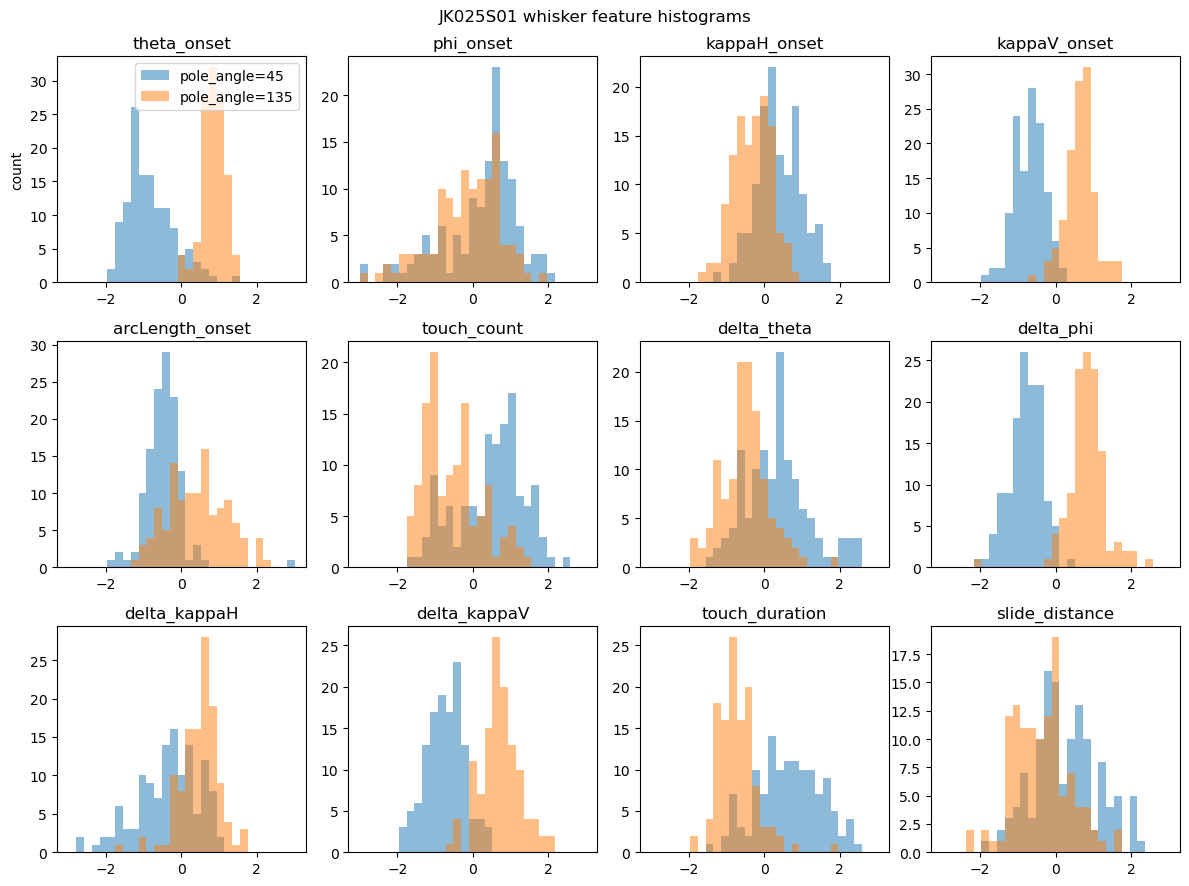

In [83]:
y_vals = [0,1]
angles = [45, 135]
bins = np.linspace(-3, 3, 30)
fig, ax = plt.subplots(3,4, figsize=(12,9))
for i in range(len(whisker_feature_names)):
    row = i // 4
    col = i % 4
    feature_values = X.sel(whisker_feature=whisker_feature_names[i]).values
    std_feature = (feature_values - feature_values.mean()) / feature_values.std()
    for yi in y_vals:
        ax[row, col].hist(std_feature[y==yi], bins=bins, alpha=0.5, label=f'pole_angle={angles[yi]}')
    ax[row, col].set_title(whisker_feature_names[i])
ax[0,0].legend()
ax[0,0].set_ylabel('count')
plt.suptitle(f'JK{mouse:03}S{session:02} whisker feature histograms')
plt.tight_layout()


In [109]:
def get_logistic_reg_accuracies(X,y, split_inds):
    num_splits = len(split_inds)
    accuracies = []
    for si in range(num_splits):
        train_inds = np.concatenate([split_inds[i] for i in range(num_splits) if i != si])
        test_inds = split_inds[si]

        X_train = X[train_inds, :]
        X_test = X[test_inds, :]
        y_train = y[train_inds]
        y_test = y[test_inds]
        
        clf = LogisticRegression()
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        accuracies.append((y_pred == y_test).mean())
    return accuracies

In [113]:
num_split = 6
splits_inds = lad.stratify_random_split(np.arange(len(y)), y, num_splits=num_split)
single_feature_accuraices_list = []
for fi in X.whisker_feature.values:
    feature_values = np.reshape(X.sel(whisker_feature=fi).values, (-1,1))
    accuracies = get_logistic_reg_accuracies(feature_values, y, splits_inds)
    single_feature_accuraices_list.append(np.mean(accuracies))
single_feature_accuraices = xr.DataArray(single_feature_accuraices_list,
                                        dims=['whisker_feature'],
                                        coords={'whisker_feature': X.whisker_feature.values})


In [114]:
single_feature_accuraices

<xarray.DataArray (whisker_feature: 12)>
array([0.93515292, 0.60288424, 0.74922571, 0.95547813, 0.78552071,
       0.75696864, 0.74487031, 0.97570654, 0.74467673, 0.92334495,
       0.87020906, 0.63162989])
Coordinates:
  * whisker_feature  (whisker_feature) <U15 'theta_onset' ... 'slide_distance'

In [140]:
def get_single_whisker_feature_angle_discrim(mouse, session, wf_dir, b_dir,
                                             touch_window='before_answer', num_split=4):
    X, y = get_x_y_for_whisker_feature_angle_discrim(wf_dir, b_dir, mouse, session,
                                                     touch_window=touch_window)
    
    splits_inds = lad.stratify_random_split(np.arange(len(y)), y, num_splits=num_split)
    single_feature_accuracies_list = []
    for fi in X.whisker_feature.values:
        feature_values = np.reshape(X.sel(whisker_feature=fi).values, (-1,1))
        accuracies = get_logistic_reg_accuracies(feature_values, y, splits_inds)
        single_feature_accuracies_list.append(np.mean(accuracies))
    single_feature_accuracies = xr.DataArray(single_feature_accuracies_list,
                                            dims=['whisker_feature'],
                                            coords={'whisker_feature': 
                                                    X.whisker_feature.values})
    return single_feature_accuracies


In [141]:
mouse = mice[0]
sessions = np.sort([int(s) for s in use_mice_df.query(
    'mouse==@mouse and session_type=="training"')['session'].unique()])
single_feature_accuracies = None
for session in sessions:
    session_single_feature_accuraices = \
        get_single_whisker_feature_angle_discrim(mouse, session, wf_dir, b_dir)
    session_single_feature_accuraices['session'] = session
    if single_feature_accuracies is None:
        single_feature_accuracies = session_single_feature_accuraices
    else:
        single_feature_accuracies = xr.concat([single_feature_accuracies, 
                                               session_single_feature_accuraices],
                                               dim='session')


Text(0.5, 1.0, 'JK025 whisker feature angle discrimination accuracy')

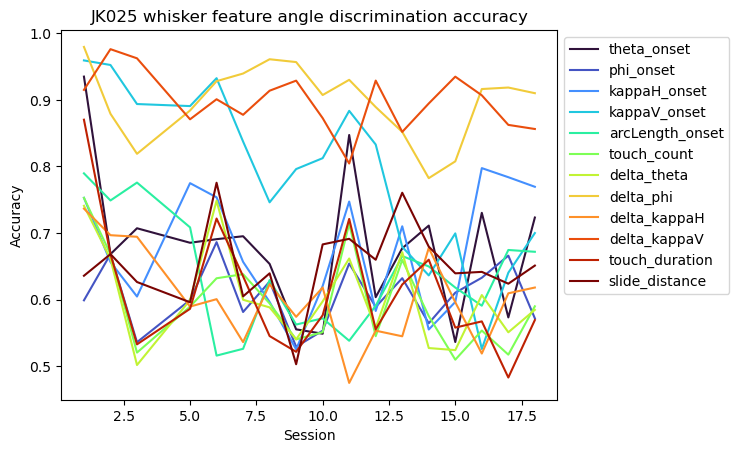

In [161]:
colors = plt.cm.get_cmap('turbo', 12)

fig, ax = plt.subplots()
for fi, feature in enumerate(single_feature_accuracies.whisker_feature.values):
    ax.plot(single_feature_accuracies['session'],
            single_feature_accuracies.sel(whisker_feature=feature).values,
            label=feature,
            color=colors(fi))
ax.legend(bbox_to_anchor=(1,1))
ax.set_xlabel('Session')
ax.set_ylabel('Accuracy')
ax.set_title(f'JK{mouse:03} whisker feature angle discrimination accuracy')

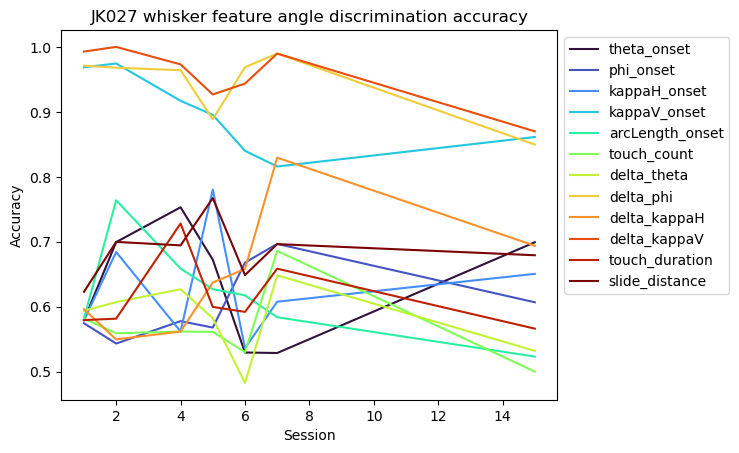

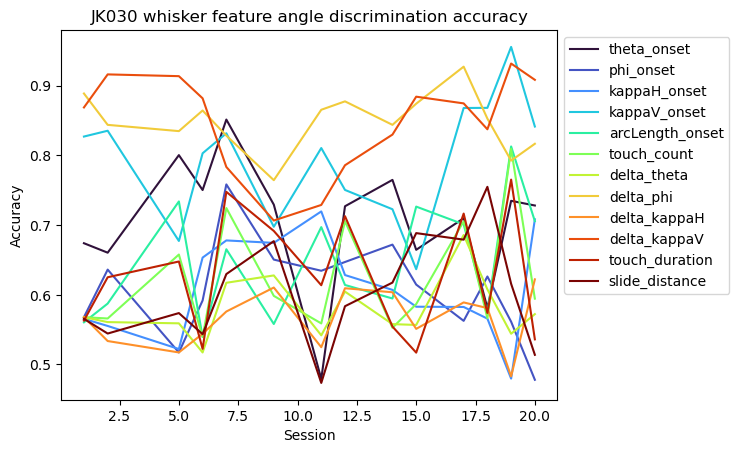

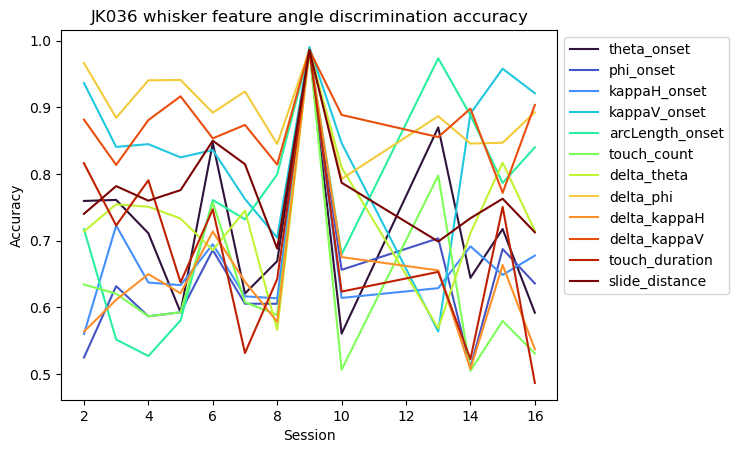

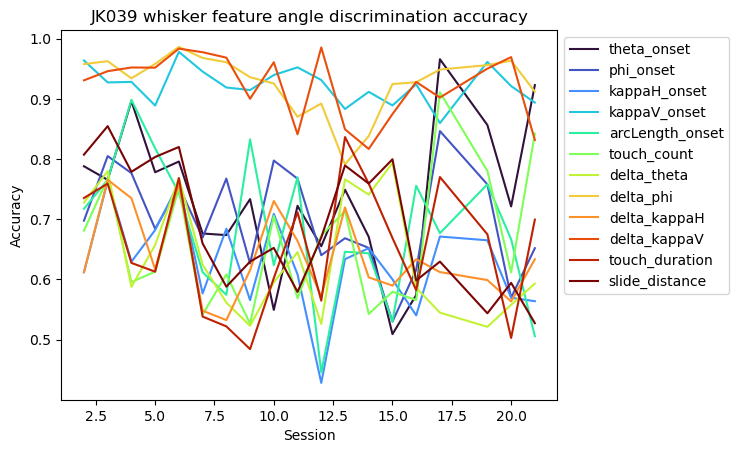

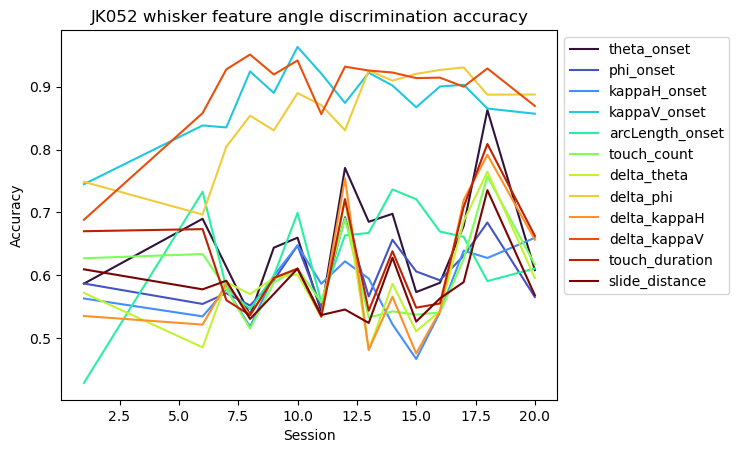

In [186]:
colors = plt.cm.get_cmap('turbo', 12)
for mouse in mice[1:]:
    sessions = np.sort([int(s) for s in use_mice_df.query(
        'mouse==@mouse and session_type=="training"')['session'].unique()])
    single_feature_accuracies = None
    for session in sessions:
        session_single_feature_accuraices = \
            get_single_whisker_feature_angle_discrim(mouse, session, wf_dir, b_dir)
        session_single_feature_accuraices['session'] = session
        if single_feature_accuracies is None:
            single_feature_accuracies = session_single_feature_accuraices
        else:
            single_feature_accuracies = xr.concat([single_feature_accuracies, 
                                                session_single_feature_accuraices],
                                                dim='session')

    fig, ax = plt.subplots()
    for fi, feature in enumerate(single_feature_accuracies.whisker_feature.values):
        ax.plot(single_feature_accuracies['session'],
                single_feature_accuracies.sel(whisker_feature=feature).values,
                label=feature,
                color=colors(fi))
    ax.legend(bbox_to_anchor=(1,1))
    ax.set_xlabel('Session')
    ax.set_ylabel('Accuracy')
    ax.set_title(f'JK{mouse:03} whisker feature angle discrimination accuracy')

# Feature correlation